In [1]:
import numpy as np
from grid import Grid

g = Grid()
g.print()

-------------------------------
| 0,0 | 1,0 | 2,0 | 3,0 | 4,0 | 
-------------------------------
| 0,1 | 1,1 | 2,1 | 3,1 | 4,1 | 
-------------------------------
| 0,2 | 1,2 | 2,2 | 3,2 | 4,2 | 
-------------------------------
| 0,3 | 1,3 | 2,3 | 3,3 | 4,3 | 
-------------------------------
| 0,4 | 1,4 | 2,4 | 3,4 | 4,4 | 
-------------------------------


# Human Tests

In [4]:
from actors import Human

h = Human(g)
h.run()

Steps: 6
Rewards: 10
---------------------
|   |   |   |   |   | 
---------------------
|   |   |   |   | o | 
---------------------
|   |   |   |   |   | 
---------------------
|   |   |   |   |   | 
---------------------
|   |   |   |   |   | 
---------------------
(4, 1)


# AI

## Q-Learning

In [2]:
from actors import QLearning

q = QLearning(g)
q.run()

print('Steps:', q.steps)
print('Rewards:', q.totalReward)


Steps: 456
Rewards: -86


In [3]:
for episodes in range(500):
    q.resetCount()
    q.run()

print('Episodes:', episodes)
print('Steps:', q.steps)
print('Rewards:', q.totalReward)

Episodes: 499
Steps: 28
Rewards: 4


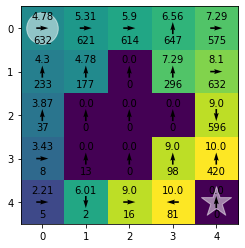

In [4]:
x = q.plot()

## Dyna-Q

In [2]:
from actors import DynaQ

d = DynaQ(g)
d.run()

print('Steps:', d.steps)
print('Rewards:', d.totalReward)

Steps: 2725
Rewards: -99


In [3]:
for episodes in range(500):
    d.resetCount()
    d.run()

print('Episodes:', episodes)
print('Steps:', d.steps)
print('Rewards:', d.totalReward)

Episodes: 499
Steps: 8
Rewards: 10


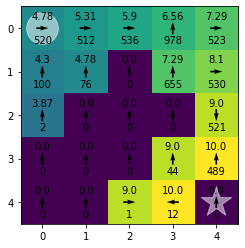

In [4]:
d.plot()

## Priority Sweeping 

In [8]:
from actors import PiorSweep

p = PiorSweep(g)
p.run()

print('Steps:', p.steps)
print('Rewards:', p.totalReward)

Steps: 3066
Rewards: -158


In [9]:
for episodes in range(100):
    p.resetCount()
    p.run(epsilon=0.1)

print('Episodes:', episodes)
print('Steps:', p.steps)
print('Rewards:', p.totalReward)

Episodes: 99
Steps: 11
Rewards: 9


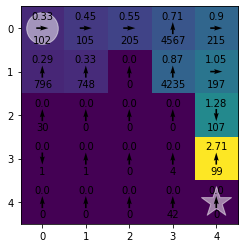

In [10]:
p.plot()

# Imitation Learning

## Mocked

In [66]:
pi = {step['s']:step['a'] for step in d.trajectory}

def generate(T=8):
    s = (0,0)
    end = False
    while not end:
        a = pi[s]
        yield s, a
        s, _, end = d.g.transition(s, a)

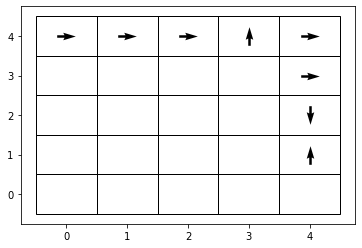

In [67]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import math

fig = plt.figure()
ax = fig.gca()

arrows = np.array([(0,1) for y in range(5,0,-1) for x in range(5)])
arrows = arrows.reshape([5,5, 2])

x = ax.quiver(range(5), range(5), arrows[:, :, 0], arrows[:, :, 1], pivot='mid', color=(0,0,0,0))
for s, a in generate(): 
    angle = math.atan2(-a[1], a[0]) * 180 / math.pi 
    ax.quiverkey(x, s[0], 4-s[1], 1, label=f'', angle=angle, color=(0,0,0,1), coordinates='data')
for y in range(5):
    for x in range(5):
        rect = patches.Rectangle((x-.5, y-.5), 1, 1, fc=(0,0,0,0), linewidth=1, edgecolor='black', facecolor='w', zorder=2)
        ax.add_patch(rect)

## Infering

In [30]:
from actors import BehavioralCloning

bc = BehavioralCloning(g)
# bc.imitate([h.trajectory, q.trajectory, d.trajectory, p.trajectory])
bc.imitate(d.trajectory)
bc.pi([3,0])

(1, 0)

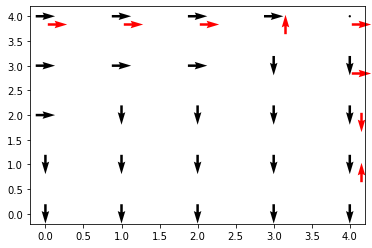

In [43]:
import matplotlib.pyplot as plt
import math

fig = plt.figure()
ax = fig.gca()

arrows = np.array([bc.pi([x,y]) for y in range(5,0,-1) for x in range(5)])
arrows = arrows.reshape([5,5, 2])

x = ax.quiver(range(5), range(5), arrows[:, :, 0], arrows[:, :, 1], pivot='mid')
for step in d.trajectory:   
    s,a = step['s'], step['a'] 
    angle = math.atan2(-a[1], a[0]) * 180 / math.pi 
    ax.quiverkey(x, s[0]+.15, 4-s[1]-.15, 1, label=f'', angle=angle, color='r', coordinates='data')


## Option Discovery 

In [63]:
pi1 = {(0,0): (1,0), (1,0): (1,0), (2,0): (1,0),  (4,2): (0,1)}
pi2 = {(3,0): (0,-1), (4,0): (1,0), (4,1): (1,0)}
pi3 = {(4,3): (0,-1)}

psi = {(3,0): 1, (4,2): 1, (4,3): 1}
eta = {(0,0): pi1, (3,0): pi2, (4,2): pi1, (4,3): pi3}

def generate(T=8):
    b = 1
    s = (0,0)
    h=None
    end = False
    while not end:
        if b == 1:
            h = eta[s]
            b = 0
        else:
            a = h[s]
            yield s, a
            s, _, end = d.g.transition(s, a)
            b = psi.get(s, 0)

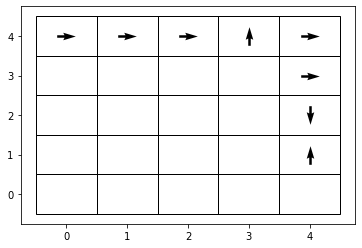

In [65]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import math

fig = plt.figure()
ax = fig.gca()

arrows = np.array([(0,1) for y in range(5,0,-1) for x in range(5)])
arrows = arrows.reshape([5,5, 2])

x = ax.quiver(range(5), range(5), arrows[:, :, 0], arrows[:, :, 1], pivot='mid', color=(0,0,0,0))
for s, a in generate(): 
    angle = math.atan2(-a[1], a[0]) * 180 / math.pi 
    ax.quiverkey(x, s[0], 4-s[1], 1, label=f'', angle=angle, color=(0,0,0,1), coordinates='data')
for y in range(5):
    for x in range(5):
        rect = patches.Rectangle((x-.5, y-.5), 1, 1, fc=(0,0,0,0), linewidth=1, edgecolor='black', facecolor='w', zorder=2)
        ax.add_patch(rect)

# Tests Gradientes

In [226]:
import numpy as np

def f(*theta):
    # return sum([n**i for i,n in enumerate(theta)])
    return theta[0]**2 * theta[1]**3 - 4*theta[1]

def gradient(f, theta, h=0.0001):
    df_dn = lambda x: (f(*[n+h if n==x else n for n in theta]) - f(*theta)) / h
    return np.array([df_dn(n) for n in theta])


p = [[2,-1]]
gradient(f=f, theta=[np.array(l) for l in zip(*p)])

array([[-4.0001    ],
       [ 7.99880004]])